In [1]:
pip install selenium beautifulsoup4 pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime

In [3]:
# Path to ChromeDriver
path = "D:\\chromedriver-win64\\chromedriver.exe"

# URL to be accessed 
url_most_popular = "https://www.imdb.com/chart/moviemeter/?ref_=nv_mv_mpmb"


# IF YOU WANT TO DO HEADLESS BROWSER, use codes below
options = Options()
options.headless = False  # Change to True if you want to run the browser in headless mode
service = Service(path)

# THIS IS FOR NORMAL BROWSER SESSION (NOT HEADLESS)
# Define browser to get the first URL
browser = webdriver.Chrome(service=service, options=options) 

# Define browser to get the second/detail URL
browser2 = webdriver.Chrome(service=service, options=options)

# Check file availability and content is not empty
filename = "imdb_mostpopular_1.csv"
filename2 = "imdb_mostpopular_2.csv"

def visualize_data():
    print("Visualize Something")
    
if os.path.isfile(filename) and os.path.getsize(filename) > 0:   
    os.remove(filename)
    os.remove(filename2)

# Initialize file handlers outside try block
f = open(filename, "w", encoding="utf-8")
fheaders = "Name,Link\n"
f.write(fheaders)

f2 = open(filename2, "w", encoding="utf-8")
f2headers = "Name,Budget,Gross_US,Opening_Week,Open_Week_Date,Gross_World,Runtime,Color,Sound_Mix,Aspect_Ratio\n"
f2.write(f2headers)

try:
    # Open session for first URL
    browser.get(url_most_popular)
    
    # We are going to have 2 different actions for "browser"
    # 1. Looking for primary data for each movie in the LIST
    # 2. Looking for LIST of movies based on the search and links to detail page
    #    and then run "browser2" to get the page using the link and extract 
    #    additional data for each movie in the LIST

    # ACTION 1
    first_page = BeautifulSoup(browser.page_source, 'html.parser')
    movies = first_page.find_all("div", {"class": "sc-b189961a-0 hBZnfJ cli-children"})
    
    count = 0
    print("PRIMARY DATA")
    print("-----------------------------------")
    for movie in movies:
        count += 1
        name = re.sub(r"\d+. ", "", movie.find("h3", {"class": "ipc-title__text"}).text)
        link_suffix = movie.find("a")["href"]
        link = "https://www.imdb.com" + link_suffix
        
        # print("-----------------------------------")
        print(name + "," + link)  
        f.write(name + "," + link + "\n")
    
    # ACTION 2
    links = browser.find_elements(By.XPATH, '//div[@class="sc-b189961a-0 hBZnfJ cli-children"]')

    count2 = 0
    print("=====================================")
    print("SECONDARY DATA")
    print("panjang ", len(links))
    print("-----------------------------------")
    movie_titles = first_page.find_all("div", {"class": "ipc-title ipc-title--base ipc-title--title ipc-title-link-no-icon ipc-title--on-textPrimary sc-b189961a-9 iALATN cli-title"})

    # Masuk ke link film
    for link, title in zip(links, movie_titles):
        title = re.sub(r"\d+. ", "", title.text)
        print("judul ke-" + str(count2+1) + ": " + title)
        # Menambahkan penundaan sebelum mengambil halaman detail
        time.sleep(1)
        # Menggunakan WebDriverWait untuk menunggu tautan muncul
        WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, '//div[@class="sc-b189961a-0 hBZnfJ cli-children"]')))
        
        count2 += 1
        budget_num = 0
        gross_us_num = 0
        open_week_rev_num = 0
        open_week_date_std = "1900-01-01 00:00:00"
        gross_world_num = 0
        runtime = 0
        color = ""
        sound_mix = ""
        aspect_ratio = ""

        # print("----------------------")
        detail_link = link.find_element(By.TAG_NAME, 'a').get_attribute('href')
        print(count2, detail_link)
        browser2.get(detail_link)

        # BOX OFFICE DATA ON THE 2ND URL
        det_page = browser2.page_source        
        container_rows = BeautifulSoup(det_page, "html.parser")        
        box_office_elements = container_rows.find("div", {"data-testid": "title-boxoffice-section"})
        tech_spech_elements = container_rows.find("div", {"data-testid": "title-techspecs-section"})

        if box_office_elements is not None:
            det_movie1 = box_office_elements.find_all("span", {"class": "ipc-metadata-list-item__list-content-item"})
            det_movie2 = tech_spech_elements.find_all("div", {"class": "ipc-metadata-list-item__content-container"})

            # BOX OFFICE
            if len(det_movie1) > 4:
                budget = det_movie1[0].text
                gross_us = det_movie1[1].text
                open_week_rev = det_movie1[2].text
                open_week_date = det_movie1[3].text            
                gross_world = det_movie1[4].text

                # print("=====================================")
                budget_num = int(re.sub("[A-Z£€₹$,()a-z]", "", budget))
                gross_us_num = int(re.sub("[A-Z£€₹$,()a-z]", "", gross_us))
                open_week_rev_num = int(re.sub("[A-Z£€₹$,()a-z]", "", open_week_rev))
                open_week_date_std = datetime.strptime(open_week_date, "%b %d, %Y")
                gross_world_num = int(re.sub("[A-Z£€₹$,()a-z]", "", gross_world))

                # print("Data has been formatted to standard")
                # print("-----------------------------------")
                print("budget =", budget_num)
                print("gross_us =", gross_us_num)
                print("opening_week_rev =", open_week_rev_num)
                print("opening_week_date =", open_week_date_std)
                print("gross_world =", gross_world_num)

            # TECHNICAL SPECS
            if len(det_movie2) > 3:
                # runtime
                runtime_elems = det_movie2[0]
                if runtime_elems:
                    runtime_text = runtime_elems.get_text(strip=True)  # Ambil teks dari elemen dengan menghilangkan spasi di awal/akhir
                    runtime_text_cleaned = runtime_text.replace("<!-- -->", "") # Bersihkan teks untuk menghilangkan bagian yang tidak diinginkan
                    # Gunakan regex untuk menemukan jam dan menit
                    hours_match = re.search(r'(\d+)\s*hour', runtime_text_cleaned)
                    minutes_match = re.search(r'(\d+)\s*minute', runtime_text_cleaned)
                    hours = int(hours_match.group(1)) if hours_match else 0
                    minutes = int(minutes_match.group(1)) if minutes_match else 0
                    runtime = hours * 60 + minutes
                else:
                    runtime = 0
                
                # color
                color_elem = det_movie2[1].find("a", class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
                color = color_elem.text.strip() if color_elem else ""
                
                # sound_mix
                sound_mix_elem = det_movie2[2].find_all("a", class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
                if sound_mix_elem:
                    sound_mix = "; ".join([item.text.strip() for item in sound_mix_elem])
                else:
                    sound_mix = ""

                # aspect_ratio
                aspect_ratio_elem = det_movie2[3].find("span", class_="ipc-metadata-list-item__list-content-item")
                aspect_ratio_text = aspect_ratio_elem.text.strip() if aspect_ratio_elem else ""
                aspect_ratio = re.sub(r'\s*:\s*', ' : ', aspect_ratio_text)
            
                print("runtime:", runtime)
                print("color:", color)
                print("sound_mix:", sound_mix)
                print("aspect_ratio:", aspect_ratio)
        
        # Simpan ke CSV
        f2.write(str(title) + "," + str(budget_num) + "," + str(gross_us_num) + "," + str(open_week_rev_num) + "," + str(open_week_date_std) + "," + str(gross_world_num) + "," + str(runtime) + "," + str(color) + "," + str(sound_mix) + "," + str(aspect_ratio) + "\n")
        print("-----------------------------------")
        
except Exception as E:
    print(E)
finally:
    f.close()
    f2.close()

PRIMARY DATA
-----------------------------------
Hit Man,https://www.imdb.com/title/tt20215968/?ref_=chtmvm_t_1
Bad Boys: Ride or Die,https://www.imdb.com/title/tt4919268/?ref_=chtmvm_t_2
Inside Out 2,https://www.imdb.com/title/tt22022452/?ref_=chtmvm_t_3
Furiosa: A Mad Max Saga,https://www.imdb.com/title/tt12037194/?ref_=chtmvm_t_4
Under Paris,https://www.imdb.com/title/tt13964390/?ref_=chtmvm_t_5
The Watchers,https://www.imdb.com/title/tt26736843/?ref_=chtmvm_t_6
The Fall Guy,https://www.imdb.com/title/tt1684562/?ref_=chtmvm_t_7
Godzilla Minus One,https://www.imdb.com/title/tt23289160/?ref_=chtmvm_t_8
Civil War,https://www.imdb.com/title/tt17279496/?ref_=chtmvm_t_9
Inside Out,https://www.imdb.com/title/tt2096673/?ref_=chtmvm_t_10
Dune: Part Two,https://www.imdb.com/title/tt15239678/?ref_=chtmvm_t_11
Kingdom of the Planet of the Apes,https://www.imdb.com/title/tt11389872/?ref_=chtmvm_t_12
The Strangers: Chapter 1,https://www.imdb.com/title/tt22050754/?ref_=chtmvm_t_13
Munjya,https://w

In [4]:
import pandas as pd
filename1 = "imdb_mostpopular_1.csv"
filename2 = "imdb_mostpopular_2.csv"

filename3 = 'imdb_mostpopular_combined.csv'

if os.path.isfile(filename3) and os.path.getsize(filename3) > 0:      
    os.remove(filename3)
    
# Read CSV files into dataframes
df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)

merged = df1.merge(df2,on='Name')
merged.to_csv("imdb_mostpopular_combined.csv", index=False)

# Display the first few rows of the combined data
print(merged.head())

                      Name                                               Link  \
0                  Hit Man  https://www.imdb.com/title/tt20215968/?ref_=ch...   
1    Bad Boys: Ride or Die  https://www.imdb.com/title/tt4919268/?ref_=cht...   
2             Inside Out 2  https://www.imdb.com/title/tt22022452/?ref_=ch...   
3  Furiosa: A Mad Max Saga  https://www.imdb.com/title/tt12037194/?ref_=ch...   
4              Under Paris  https://www.imdb.com/title/tt13964390/?ref_=ch...   

      Budget   Gross_US  Opening_Week       Open_Week_Date  Gross_World  \
0          0          0             0  1900-01-01 00:00:00            0   
1  100000000  120693327      56527324  2024-06-09 00:00:00    223179517   
2  200000000  205448790     154201673  2024-06-16 00:00:00    379748790   
3  168000000   64020267      26326462  2024-05-26 00:00:00    161020267   
4          0          0             0  1900-01-01 00:00:00            0   

   Runtime  Color                                          Sou

In [5]:
data = pd.read_csv("imdb_mostpopular_combined.csv")
data

,Name,Link,Budget,Gross_US,Opening_Week,Open_Week_Date,Gross_World,Runtime,Color,Sound_Mix,Aspect_Ratio
0,Hit Man,https://www.imdb.com/title/tt20215968/?ref_=ch...,0,0,0,1900-01-01 00:00:00,0,115,Color,Dolby Digital,2.39 : 1
1,Bad Boys: Ride or Die,https://www.imdb.com/title/tt4919268/?ref_=cht...,100000000,120693327,56527324,2024-06-09 00:00:00,223179517,115,Color,Dolby Digital; IMAX 6-Track; Dolby Atmos,2.39 : 1
2,Inside Out 2,https://www.imdb.com/title/tt22022452/?ref_=ch...,200000000,205448790,154201673,2024-06-16 00:00:00,379748790,96,Color,Dolby Digital; Dolby Atmos; Sonics-DDP; Auro 1...,2.39 : 1
3,Furiosa: A Mad Max Saga,https://www.imdb.com/title/tt12037194/?ref_=ch...,168000000,64020267,26326462,2024-05-26 00:00:00,161020267,148,Color,IMAX 6-Track; Dolby Surround 7.1; Dolby Atmos;...,2.39 : 1
4,Under Paris,https://www.imdb.com/title/tt13964390/?ref_=ch...,0,0,0,1900-01-01 00:00:00,0,104,Color,Dolby Digital,1.78 : 1
...,...,...,...,...,...,...,...,...,...,...,...
95,The Gentlemen,https://www.imdb.com/title/tt8367814/?ref_=cht...,22000000,36471795,10651884,2020-01-26 00:00:00,115175729,113,Color,Dolby Digital; Dolby Surround 7.1; Dolby Atmos,2.39 : 1
96,Fright Night,https://www.imdb.com/title/tt0089175/?ref_=cht...,9000000,24922237,6118543,1985-08-04 00:00:00,24923585,106,Color,Dolby Stereo; Dolby Atmos,2.39 : 1
97,The Zone of Interest,https://www.imdb.com/title/tt7160372/?ref_=cht...,0,0,0,1900-01-01 00:00:00,0,105,Color,Dolby Digital,1.78 : 1
98,Everybody Wants Some!!,https://www.imdb.com/title/tt2937696/?ref_=cht...,10000000,3400278,312355,2016-04-03 00:00:00,4644472,117,Color,Dolby Digital; Datasat; Dolby Surround 7.1,1.85 : 1


In [6]:
# DATA TYPE
print(data.dtypes)

Name              object
Link              object
Budget             int64
Gross_US           int64
Opening_Week       int64
Open_Week_Date    object
Gross_World        int64
Runtime            int64
Color             object
Sound_Mix         object
Aspect_Ratio      object
dtype: object


In [7]:
# cek data missing value
data.isnull().sum()

Name               0
Link               0
Budget             0
Gross_US           0
Opening_Week       0
Open_Week_Date     0
Gross_World        0
Runtime            0
Color             40
Sound_Mix         40
Aspect_Ratio      40
dtype: int64

In [8]:
data_clean = data.dropna()

In [9]:
data_clean = data_clean[data_clean['Budget'] != 0]

In [10]:
# Periksa jumlah nilai yang hilang setelah pembersihan
print(data_clean.isnull().sum())

# Periksa apakah ada nilai budget yang nol setelah pembersihan
print(data_clean[data_clean['Budget'] == 0])

Name              0
Link              0
Budget            0
Gross_US          0
Opening_Week      0
Open_Week_Date    0
Gross_World       0
Runtime           0
Color             0
Sound_Mix         0
Aspect_Ratio      0
dtype: int64
Empty DataFrame
Columns: [Name, Link, Budget, Gross_US, Opening_Week, Open_Week_Date, Gross_World, Runtime, Color, Sound_Mix, Aspect_Ratio]
Index: []


In [11]:
data_clean

,Name,Link,Budget,Gross_US,Opening_Week,Open_Week_Date,Gross_World,Runtime,Color,Sound_Mix,Aspect_Ratio
1,Bad Boys: Ride or Die,https://www.imdb.com/title/tt4919268/?ref_=cht...,100000000,120693327,56527324,2024-06-09 00:00:00,223179517,115,Color,Dolby Digital; IMAX 6-Track; Dolby Atmos,2.39 : 1
2,Inside Out 2,https://www.imdb.com/title/tt22022452/?ref_=ch...,200000000,205448790,154201673,2024-06-16 00:00:00,379748790,96,Color,Dolby Digital; Dolby Atmos; Sonics-DDP; Auro 1...,2.39 : 1
3,Furiosa: A Mad Max Saga,https://www.imdb.com/title/tt12037194/?ref_=ch...,168000000,64020267,26326462,2024-05-26 00:00:00,161020267,148,Color,IMAX 6-Track; Dolby Surround 7.1; Dolby Atmos;...,2.39 : 1
6,The Fall Guy,https://www.imdb.com/title/tt1684562/?ref_=cht...,125000000,88247580,27747035,2024-05-05 00:00:00,169774694,126,Color,Dolby Atmos; IMAX 6-Track,2.39 : 1
7,Godzilla Minus One,https://www.imdb.com/title/tt23289160/?ref_=ch...,15000000,56418793,11419975,2023-12-03 00:00:00,115857413,124,Color,Dolby Atmos; IMAX 6-Track,2.39 : 1
8,Civil War,https://www.imdb.com/title/tt17279496/?ref_=ch...,50000000,68549137,25537368,2024-04-14 00:00:00,114373168,109,Color,Dolby Digital; IMAX 6-Track; Dolby Atmos,1.85 : 1
9,Inside Out,https://www.imdb.com/title/tt2096673/?ref_=cht...,175000000,356921711,90440272,2015-06-21 00:00:00,858852998,95,Color,Dolby Digital; Datasat; Dolby Atmos; SDDS; Dol...,1.78 : 1
11,Kingdom of the Planet of the Apes,https://www.imdb.com/title/tt11389872/?ref_=ch...,160000000,159460045,58400788,2024-05-12 00:00:00,376553863,145,Color,Dolby Digital; 12-Track Digital Sound; Dolby A...,2.39 : 1
14,Challengers,https://www.imdb.com/title/tt16426418/?ref_=ch...,55000000,49950208,15011061,2024-04-28 00:00:00,94050208,131,Color,Dolby Digital; Dolby Atmos,1.85 : 1
17,Mad Max: Fury Road,https://www.imdb.com/title/tt1392190/?ref_=cht...,150000000,154280290,45428128,2015-05-17 00:00:00,380418444,120,Color,Dolby Digital; Datasat; SDDS; Dolby Atmos,2.39 : 1


In [12]:
data_clean.to_csv('imdb_mostpopular_clean.csv', index=False)

# VISUALISASI HASIL SCRAPING

In [13]:
# Membaca data dari file CSV
data = pd.read_csv("imdb_mostpopular_clean.csv")

In [14]:
data

,Name,Link,Budget,Gross_US,Opening_Week,Open_Week_Date,Gross_World,Runtime,Color,Sound_Mix,Aspect_Ratio
0,Bad Boys: Ride or Die,https://www.imdb.com/title/tt4919268/?ref_=cht...,100000000,120693327,56527324,2024-06-09 00:00:00,223179517,115,Color,Dolby Digital; IMAX 6-Track; Dolby Atmos,2.39 : 1
1,Inside Out 2,https://www.imdb.com/title/tt22022452/?ref_=ch...,200000000,205448790,154201673,2024-06-16 00:00:00,379748790,96,Color,Dolby Digital; Dolby Atmos; Sonics-DDP; Auro 1...,2.39 : 1
2,Furiosa: A Mad Max Saga,https://www.imdb.com/title/tt12037194/?ref_=ch...,168000000,64020267,26326462,2024-05-26 00:00:00,161020267,148,Color,IMAX 6-Track; Dolby Surround 7.1; Dolby Atmos;...,2.39 : 1
3,The Fall Guy,https://www.imdb.com/title/tt1684562/?ref_=cht...,125000000,88247580,27747035,2024-05-05 00:00:00,169774694,126,Color,Dolby Atmos; IMAX 6-Track,2.39 : 1
4,Godzilla Minus One,https://www.imdb.com/title/tt23289160/?ref_=ch...,15000000,56418793,11419975,2023-12-03 00:00:00,115857413,124,Color,Dolby Atmos; IMAX 6-Track,2.39 : 1
5,Civil War,https://www.imdb.com/title/tt17279496/?ref_=ch...,50000000,68549137,25537368,2024-04-14 00:00:00,114373168,109,Color,Dolby Digital; IMAX 6-Track; Dolby Atmos,1.85 : 1
6,Inside Out,https://www.imdb.com/title/tt2096673/?ref_=cht...,175000000,356921711,90440272,2015-06-21 00:00:00,858852998,95,Color,Dolby Digital; Datasat; Dolby Atmos; SDDS; Dol...,1.78 : 1
7,Kingdom of the Planet of the Apes,https://www.imdb.com/title/tt11389872/?ref_=ch...,160000000,159460045,58400788,2024-05-12 00:00:00,376553863,145,Color,Dolby Digital; 12-Track Digital Sound; Dolby A...,2.39 : 1
8,Challengers,https://www.imdb.com/title/tt16426418/?ref_=ch...,55000000,49950208,15011061,2024-04-28 00:00:00,94050208,131,Color,Dolby Digital; Dolby Atmos,1.85 : 1
9,Mad Max: Fury Road,https://www.imdb.com/title/tt1392190/?ref_=cht...,150000000,154280290,45428128,2015-05-17 00:00:00,380418444,120,Color,Dolby Digital; Datasat; SDDS; Dolby Atmos,2.39 : 1


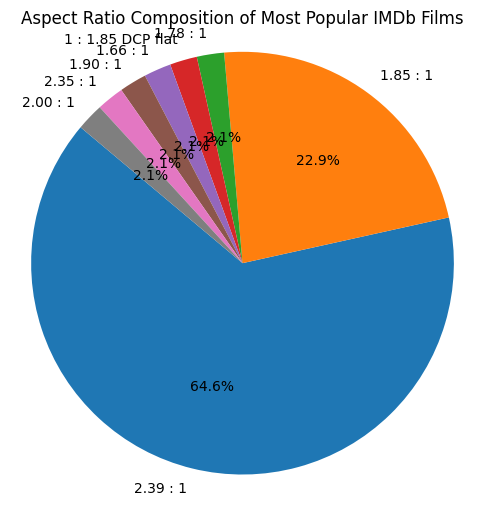

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Menghitung jumlah film untuk setiap aspect ratio
aspect_ratio_counts = data['Aspect_Ratio'].value_counts()

# Plotting pie chart
plt.figure(figsize=(6, 6))
plt.pie(aspect_ratio_counts, labels=aspect_ratio_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Aspect Ratio Composition of Most Popular IMDb Films')
plt.axis('equal')  # Mengatur aspek ratio pie chart agar terlihat seperti lingkaran
plt.show()


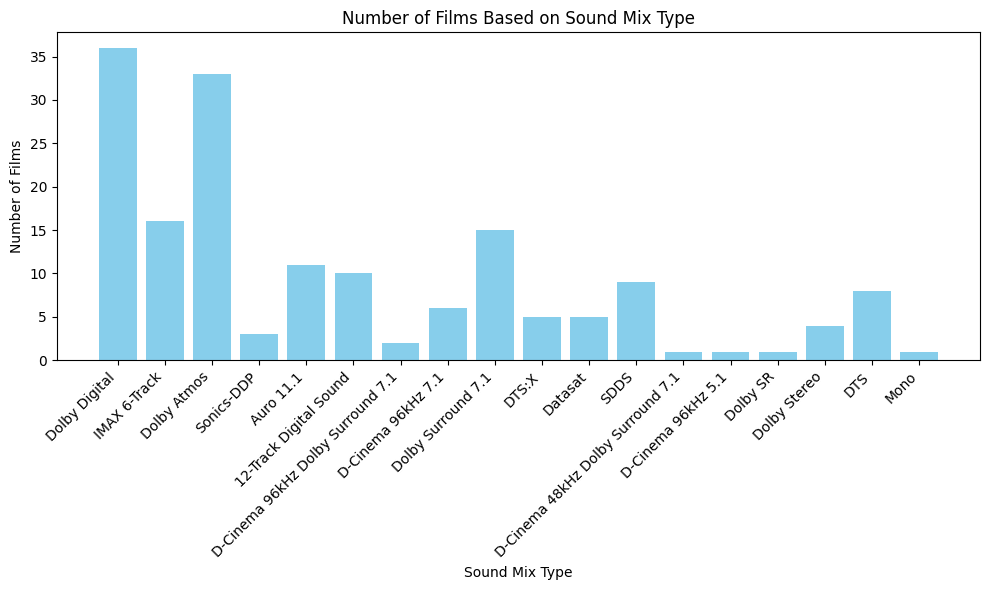

In [16]:
from collections import defaultdict
import numpy as np

# Dictionary to count the occurrences of each sound mix type
sound_mix_counts = defaultdict(int)

# Iterate through the list of sound mixes for each film
for sound_mix_str in data['Sound_Mix']:
    if isinstance(sound_mix_str, str):  # Check if the value is a string
        sound_mixes = sound_mix_str.split(';')
        for sound_mix in sound_mixes:
            sound_mix_counts[sound_mix.strip()] += 1
    elif isinstance(sound_mix_str, float) and np.isnan(sound_mix_str):  # Check if the value is NaN
        # Handling if the value is NaN
        pass
    else:
        print("Value Error:", sound_mix_str)

# Create visualization
plt.figure(figsize=(10, 6))
plt.bar(sound_mix_counts.keys(), sound_mix_counts.values(), color='skyblue')
plt.xlabel('Sound Mix Type')
plt.ylabel('Number of Films')
plt.title('Number of Films Based on Sound Mix Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


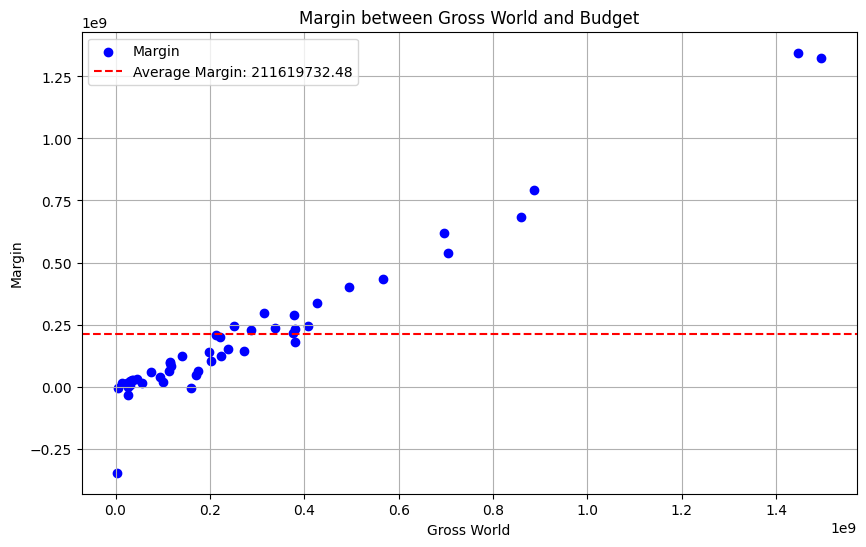

In [22]:
import matplotlib.pyplot as plt

# Data
budget = data['Budget']
gross_world = data['Gross_World']

# Calculate the margin
margin = gross_world - budget

# Calculate the average margin
average_margin = margin.mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(gross_world, margin, color='blue', label='Margin')

# Add horizontal line for the average margin
plt.axhline(y=average_margin, color='red', linestyle='--', label=f'Average Margin: {average_margin:.2f}')

# Add title and axis labels
plt.title('Margin between Gross World and Budget')
plt.xlabel('Gross World')
plt.ylabel('Margin')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


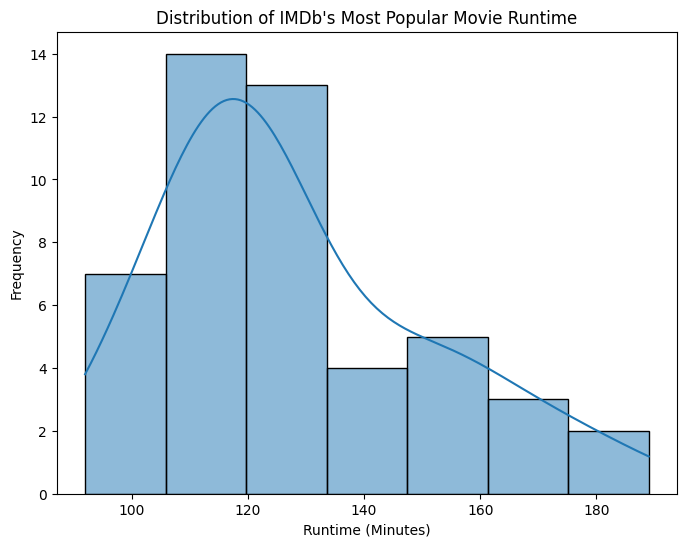

In [18]:
# Visualisasi DISTRIBUTION
plt.figure(figsize=(8, 6))
sns.histplot(data['Runtime'], kde=True)
plt.title('Distribution of IMDb\'s Most Popular Movie Runtime')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Frequency')
plt.show()

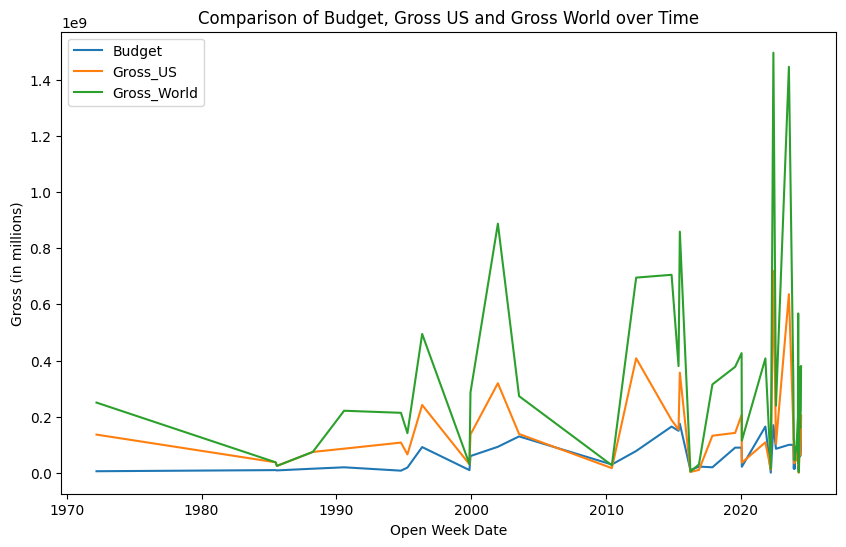

In [19]:
data['Open_Week_Date'] = pd.to_datetime(data['Open_Week_Date'])
data = data.sort_values('Open_Week_Date')

plt.figure(figsize=(10, 6))
plt.plot(data['Open_Week_Date'], data['Budget'], label='Budget')
plt.plot(data['Open_Week_Date'], data['Gross_US'], label='Gross_US')
plt.plot(data['Open_Week_Date'], data['Gross_World'], label='Gross_World')
plt.title('Comparison of Budget, Gross US and Gross World over Time')
plt.xlabel('Open Week Date')
plt.ylabel('Gross (in millions)')
plt.legend()
plt.show()


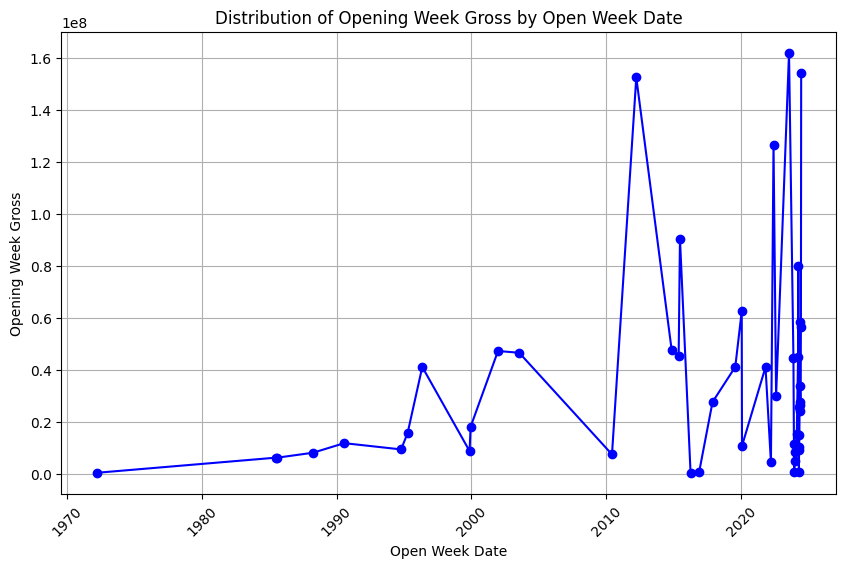

In [20]:
data_imdb = pd.DataFrame(data)

# Mengubah kolom Open_Week_Date menjadi datetime
data_imdb['Open_Week_Date'] = pd.to_datetime(data_imdb['Open_Week_Date'])

# Mengurutkan data berdasarkan Open_Week_Date
data_imdb = data_imdb.sort_values('Open_Week_Date')

# Membuat line chart menggunakan matplotlib
plt.figure(figsize=(10, 6))
plt.plot(data_imdb['Open_Week_Date'], data_imdb['Opening_Week'], marker='o', linestyle='-', color='b')
plt.title('Distribution of Opening Week Gross by Open Week Date')
plt.xlabel('Open Week Date')
plt.ylabel('Opening Week Gross')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()